In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import MDAnalysis as mda
import mdtraj as md
from Bio import SeqIO


## Functions

In [2]:
def interacting_residues(prot): 

    f = open(prot+'.xml', 'r')
    residues = []
    for line in f:
        if 'contact="True"' in line:
            ls = line.split('>')
            result = ''.join([i for i in ls[1] if  i.isdigit()])
            residues.append(result)
            
    return residues

In [3]:
def prot_res_nums(name):
    pdb = open(name+'.pdb', 'r')
    c = 0 
    res_num = 0
    for line in pdb: 
        ls = line.split()
        if ls[0] == 'ATOM':
            res_num_tmp = int(ls[5])
            if c == 0:
                start_res = int(ls[5]) 
                c += 1
            if res_num_tmp > res_num:
                res_num = res_num_tmp

    pdb.close()
    
    return res_num, start_res

In [4]:
def fill_array(res_num, residues):
    full_plif_string = np.zeros(int(res_num))
    for i in residues:
        full_plif_string[int(i)-1] = 1
    
    return full_plif_string

In [5]:
def plif_tanimoto(xtal, pred):
    onA = np.where(xtal == 1)
    onB = np.where(pred == 1)
    onBoth = len(set(onA[0]) & set(onB[0]))
    onlyA = len(list(set(onA[0]) - set(onB[0])))
    onlyB = len(list(set(onB[0]) - set(onA[0])))
    ts = onBoth / (onlyA + onlyB + onBoth)

    return ts

In [ ]:
def align_sequences(reference, target, where):

    # load pdb structures using mdanalysis 
    ref_ma = mda.Universe(where+'/'+reference+'.pdb')
    target_ma = mda.Universe(where+'/'+target+'.pdb')

    ref_resids = [a.resid for a in ref_ma.select_atoms('name CA')]
    target_resids = [a.resid for a in target_ma.select_atoms('name CA')]

    fasta = open(where+'/'+reference+'_'+target+'_fasta.txt', 'r')

    seldict = mda.analysis.align.fasta2select(where+'/'+reference+'_'+target+'_fasta.txt', ref_resids=ref_resids, target_resids=target_resids)

    l = str(seldict['reference']).split(') or (')
    residues = []
    for line in l:
        ls = line.split(' ')
        residues.append(int(ls[2]))

    return residues

In [ ]:
def write_fasta(reference, target, where):
    for record in SeqIO.parse(where+'/'+reference+'.pdb', "pdb-atom"):
        ref_seq = record.seq

    for record in SeqIO.parse(where+'/'+target+'.pdb', "pdb-atom"):
        mod_seq = record.seq

    f = open(where+'/'+reference+'_'+target+'_fasta.txt', 'w')
    f.write('> '+reference+'\n')
    f.write((str(ref_seq)+'\n'))
    f.write('\n')
    f.write('> '+target+'\n')
    f.write((str(mod_seq)+'\n'))
    f.close()

In [ ]:
def trim_reference(reference, residues, where):

    ref = md.load(where+'/'+reference+'.pdb')
    ref_top = ref.topology
    ref_df, _ = ref_top.to_dataframe()
    ref_df_cut = ref_df[ref_df['resSeq'].isin(residues)]
    ref_cut = ref.atom_slice(ref_df_cut['serial'])
    ref_cut.save_pdb(where+'/'+reference+'_trim.pdb')

# Calculate the fingerprint for crystal ligands (reference)
The code below is meant to show the steps used to compute the fingerprint similarities. It does need all the docking poses to run, hence, it is only for following the steps, not to run. If you wanto to just replicate the plot, please go to the last part of this notebook. 

First we load the kinases that we will be analyzing in this study.

In [ ]:
file = open('../data/metadata_af_plip.csv', 'r')
ref_prots = []
for line in file:
    fs = line.split(',')
    ref_prot = fs[1]
    ref_prots.append(ref_prot)
file.close()

In [ ]:
file = open('../data/metadata_af_plip.csv', 'r')
prots = []
for line in file:
    fs = line.split(',')
    prot = fs[0]
    prots.append(prot)
file.close()

#### List of proteins, and corresponding states used in the study
['GSK3B_cidi', 'PAK5_cidi', 'VRK1_cidi', 'AKT2_cidi', 'HCK_codi', 'DAPK3_cidi', 'NEK2_codi', 'ALK_cidi', 'CDK6_codi', 'ABL1_cidi', 'BTK_codi', 'SRC_codi', 'PKN1_cidi', 'PAK4_cidi', 'CDK8_cidi', 'LIMK1_cidi', 'CDKL1_cidi', 'PAK6_cidi', 'GAK_cidi', 'MELK_cidi', 'IRAK4_cidi', 'AKT1_cidi', 'IRAK1_cidi', 'CDK2_codi', 'DDR2_cido', 'PAK1_cidi', 'TNIK_cidi', 'TTBK2_cidi', 'ULK1_cidi', 'TTBK1_cidi', 'CLK2_cidi', 'PIM1_cidi', 'TTK_cidi', 'PLK2_cidi', 'DCLK1_cidi', 'ITK_codi', 'CDK5_cidi', 'ULK3_cidi', 'CLK3_cidi', 'EGFR_codi', 'MLKL_codi', 'PIM2_cidi', 'DDR1_cido', 'HIPK2_cidi', 'PLK1_cidi', 'ROCK1_cidi', 'DAPK1_cidi']

For each of these kinases and the corresponding crystal structures were prepared for calculation of the protein ligand interaction fingerprint using plip. The files with all the combinations explored are the inputs and are loaded in the last section of this notebook

In [44]:
for ref_prot in ref_prots:
    os.system('cat ../data/pose_accuracy-data/%s_trim.pdb ../data/pose_accuracy-data/%s_ligand.pdb > ../data/pose_accuracy-data/%s_trim_ligand.pdb'%(ref_prot, ref_prot, ref_prot))
    c = 0 
    f = open('../data/pose_accuracy-data/%s_trim_ligand.pdb'%(ref_prot), 'r')
    w = open('../data/pose_accuracy-data/%s_trim_ligand_cut.pdb'%(ref_prot), 'w')
    for line in f: 
        ls = line.split()
        if ls[0] == 'ATOM' or ls[0] == 'HETATM':
            w.write(line)
        if ls[0] == 'END':
            if c == 0:
                w.write('TER\n')
                c +=1 
            else:
                w.write('END\n')
    w.close()
    f.close()
                
    os.system('plip -f ../data/pose_accuracy-data/%s_trim_ligand_cut.pdb -x -q -o ../plips/ --name %s_xtal_plif '%(ref_prot, ref_prot))

# Calculate fingerprints for docked pose in AF structures
Below is an example of the steps involved into the analysis of interaction similarity.

### 1. Split the docked output into individual files 

In [ ]:
for prot in prots:
    try:
        os.system('obabel -isdf ../pose_accuracy/%s-docked.sdf -O ../pose_accuracy/%s-pose_.pdb -m' % (prot, prot))
    except:
        continue

### 2. Merge docked poses with corresponding protein
To make aplip prediction on the docked pose we have to merge the docked pose and the protein files. The connections have to be stripped, and added TER instead at the end of first block

In [133]:
for prot in prots:
    for i in range(1,10):
        c = 0 
        os.system("cat ../data/pose_accuracy-data/'{0}'_AF_superposed.pdb ../pose_accuracy/'{0}'-pose_'{1}'.pdb > ../pose_accuracy/'{0}'_all-pose_'{1}'.pdb".format(prot,str(i)))
        f = open("../pose_accuracy/{0}_all-pose_{1}.pdb".format(prot, str(i)), 'r')
        w = open("../pose_accuracy/{0}_all-pose_{1}_cut.pdb".format(prot, str(i)), 'w')
        for line in f: 
            ls = line.split()
            if ls[0] == 'ATOM' or ls[0] == 'HETATM':
                w.write(line)
            if ls[0] == 'END':
                if c == 0:
                    w.write('TER\n')
                    c +=1 
                else:
                    w.write('END\n')
        w.close()
        f.close()     

### 3. Computing protein ligand interaction fingerprint using plip. 

In [135]:
for prot in prots:
    for i in range(1,10):
        os.system('plip -f ../pose_accuracy/{0}_all-pose_{1}_cut.pdb -x -q -o ../plips/ --name {2}-docked-pose_{3}_plif'.format(prot, str(i), prot, str(i)))        

### 4. Computing PLIF similarity between docked pose and crystal

In [ ]:
ts = []
ts_prots = []
ts_states = []
# get interaction fingerprint for the crystal
for p in range(len(ref_prots)):
    ts_prots.append(prots[p])
    xtal_res_num, xtal_start_res = prot_res_nums('../data/pose_accuracy-data/'+ref_prots[p]+'_trim')
    xtal_interacting_residues = interacting_residues('../plips/'+ref_prots[p]+'_xtal_plif')
    xtal_interacting_residues_norm = [(int(i) - xtal_start_res) for i in xtal_interacting_residues]
    xtal_plif = fill_array(xtal_res_num-xtal_start_res, xtal_interacting_residues_norm)    
    pred_res_num, pred_start_res = prot_res_nums('../data/pose_accuracy-data/'+prots[p]+'_AF_superposed')
    pt = 0

    #get interaction fingerprint for the docked pose in AF structure
    for pose in range(1,10):       
        pred_res_num, pred_start_res = prot_res_nums('../data/pose_accuracy-data/'+prots[p]+'_AF_superposed')
        pred_interacting_residues = interacting_residues('../plips/'+prots[p]+'-docked-pose_'+str(pose)+'_plif')            
        pred_interacting_residues_norm = [(int(i) - pred_start_res) for i in pred_interacting_residues]
        pred_plif = fill_array(pred_res_num-pred_start_res, pred_interacting_residues_norm)
        print('pred interacting residues in AF '+prots[p]+': '+str(pred_interacting_residues_norm))
        pt_pose = plif_tanimoto(xtal_plif, pred_plif) # compute similarity
        
        # retain best pose
        if pt_pose > pt:
            pt = pt_pose
            
    ts.append(pt)

Extract conformational states for plotting

In [186]:
# Extract conformational states for plotting
states  = []
for s in prots:
    ls = s.split('_')
    states.append(ls[1])

Consolidate into dataframe

In [187]:
df = pd.DataFrame(list(zip(states, ts)), columns=['States', 'Interactions similarity'])
df.head()

,States,Interactions similarity
0,cidi,0.352941
1,cidi,0.200000
2,cidi,0.400000
3,cidi,0.416667
4,codi,0.545455


Plot

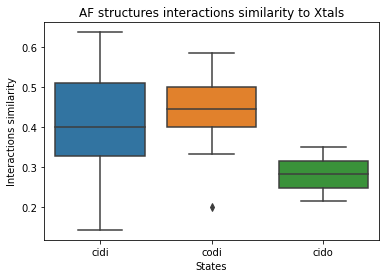

In [188]:
sns.boxplot(data=df, x='States', y='Interactions similarity')
plt.title('AF structures interactions similarity to Xtals')
plt.savefig('AF_interaction_accuracy_from_docking_vs_xtals.jpg', dpi=300)

# Evaluation of Re-docking performance of xtal structures

The preprocessing of the docking results and calculation of the plip follows the same steps as the cross docking example above. This time each crystal ligand is re-docked only in its native structure. 
After preparing the file for plip (step 1 and 2 above) and computed the plif with plip (step 3), we are now ready to build the cross-docking comparisons.

In the code below: 
- targets are the list of kinases. 
- all_prots is the list of that specifies all specific structures investigated for every kinase

In [55]:
ts = []
df_xtal_re =  pd.DataFrame(columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])

for t in range(len(targets)): # go over all the kinases
    pt_target = 0
    if targets[t] in cross_xtals_targets:
        for prot in all_prots: # go over all structures
            ps = prot.split('_')
            if ps[0] == targets[t]: # make sure we are comparing the interaction within the same kinase
                try:     
                    xtal_res_num, _ = prot_res_nums('../data/pose_accuracy-data/'+prot)
                    xtal_interacting_residues = interacting_residues('../data/pose_accuracy-data/'+prot+'_xtal_plif')
                    xtal_plif = fill_array(xtal_res_num, xtal_interacting_residues)
                    
                    pt_prot = 0
                    for pose in range(1,10):   
                        pred_res_num, _ = prot_res_nums('../../benchmark/pose_accuracy/smina/baseline/'+prot+'_all-pose_'+str(pose)+'_cut')
                        pred_interacting_residues = interacting_residues('../../benchmark/pose_accuracy/smina/baseline/'+prot+'-docked-pose_'+str(pose)+'_plif')
                        pred_plif = fill_array(pred_res_num, pred_interacting_residues) 
                        pt_pose = plif_tanimoto(xtal_plif, pred_plif) #compute similarity 

                        # retain best pose
                        if pt_pose > pt_prot:
                            pt_prot = pt_pose

                    df_tmp = pd.DataFrame(data = [[targets[t], 'xtal', prot, states[t], pt_prot]], columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])
                    df_xtal_re = pd.concat([df_xtal_re, df_tmp])
                except:
                    continue
                        
                if pt_prot > pt_target:
                    pt_target = pt_prot
            
        ts.append(pt_target)

# Evaluation of Cross-docking performance of xtal structures

We performed the same steps as the example above but this time cross-docking the ligands crystallized in a kinase all the other crystal structures of the same kinase.
The only additional step, as now we are comparing different structure which might have different lenght, hence different residue numbering, is for each kinase, to trim the structures to be all the the same length.

In the code below: 
- targets are the list of kinases. 
- all_prots is the list of that specifies all specific structures investigated for every kinase

In [ ]:
trim_failed = [] 
for t in range(len(targets)):
    for prot in all_prots:
        ps = prot.split('_')
        if ps[0] == targets[t]:
            reference = prot+'_prot'
            modeled = targets[t]+'_'+states[t].lower()+'_AF_superposed_Hs'
            try: 
                write_fasta(reference, modeled, '../data/pose_accuracy-data') #extract sequence
                residues = align_sequences(reference, modeled, '../data/pose_accuracy-data') #align sequence
                trim_reference(reference, residues, '../data/pose_accuracy-data') #trim structure to match the sequence
            except:
                trim_failed.append(prot)
                continue

After preparing the file for plip (step 1 and 2 above) and computed the plif with plip (step 3), we are now ready to build the cross-docking comparisons.

In [ ]:
df_to_plot = pd.DataFrame(columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])
for t in range(len(targets)):
    pt_target = 0

    for prot in all_prots: # Go over all the structures
        if prot not in trim_failed: # Make sure that the protein sequence are aligned
            ps = prot.split('_')

            if ps[0] == targets[t]: # Verify that the structure we are analyzing is of the right kinase
                try: 
                    xtal_res_num, xtal_start_res = prot_res_nums('../data/pose_accuracy-data/'+prot+'_prot_trim')
                    xtal_interacting_residues = interacting_residues('../plips/xtals/'+prot+'_trim-ligand_plif')
                    xtal_interacting_residues_norm = [(int(i) - xtal_start_res) for i in xtal_interacting_residues] #normalize the residue numbering
                    xtal_plif = fill_array(xtal_res_num-xtal_start_res, xtal_interacting_residues_norm)    
                    
                    # compare to the other crystal structures of the same kinase
                    for sec_prot in all_prots: 
                
                        if sec_prot not in trim_failed: 
                            s_ps = sec_prot.split('_')

                            if s_ps[0] == targets[t]:  
                                if sec_prot != prot:
                                    
                                    # compare to the other crystal structures of the same kinase
                                    pt_lig = 0
                                    for pose in range(1,10):   
                                        pred_res_num, pred_start_res = prot_res_nums('../data/pose_accuracy-data/'+sec_prot+'_prot_trim')
                                        pred_interacting_residues = interacting_residues('../plips/xtal_cross/xtal_cross_plips/{0}_{1}_lig-docked-trim-pose_{2}_plif'.format(sec_prot, ps[1], pose))
                                        pred_interacting_residues_norm = [(int(i) - pred_start_res) for i in pred_interacting_residues]
                                        pred_plif = fill_array(pred_res_num-pred_start_res, pred_interacting_residues_norm)
                                        pt_pose = plif_tanimoto(xtal_plif, pred_plif)
                                        
                                        # record_best pose
                                        if pt_pose > pt_lig:
                                            pt_lig = pt_pose

                                    df_temp = pd.DataFrame(data = [[targets[t], s_ps[1], ps[1], s_ps[2], pt_lig]],columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])
                                    df_to_plot = pd.concat([df_to_plot, df_temp])
                except:
                    continue

In [31]:
cross_xtals_targets = list(df_to_plot['Kinase'].unique())

# Cross Docking to AF structures

We follow the same steps above but on the docked files from docking crystal ligands to AF structures.

In [29]:
df_AF_to_plot = pd.DataFrame(columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])
cross_xtals_targets = list(df_to_plot['Kinase'].unique())

for t in range(len(targets)):
    if targets[t] in cross_xtals_targets:
        pt_target = 0
        for prot in all_prots: # Go over all the structures
            if prot not in trim_failed: # Make sure that the protein sequence are aligned
                ps = prot.split('_')

                if ps[0] == targets[t]: #Verify that the structure we are analyzing is of the right kinase 
                    try:
                        xtal_res_num, xtal_start_res = prot_res_nums('../data/pose_accuracy-data/'+prot+'_prot_trim')
                        xtal_interacting_residues = interacting_residues('../plips/xtals/'+prot+'_trim-ligand_plif')
                        xtal_interacting_residues_norm = [(int(i) - xtal_start_res) for i in xtal_interacting_residues]
                        xtal_plif = fill_array(xtal_res_num-xtal_start_res, xtal_interacting_residues_norm)    

                        # compare to the AF structure docked with the ligand of that the experimental structure
                        pt_prot = 0
                        for pose in range(1,10):   
                            pred_res_num, pred_start_res = prot_res_nums('../data/pose_accuracy-data/'+targets[t]+'_'+states[t].lower()+'_AF_superposed_Hs')
                            pred_interacting_residues = interacting_residues('../plips/AF_cross/{0}_{1}_{2}_lig-trim-pose_{3}_plif'.format(targets[t], states[t].lower(), ps[1], pose))
                            pred_interacting_residues_norm = [(int(i) - pred_start_res) for i in pred_interacting_residues]
                            pred_plif = fill_array(pred_res_num-pred_start_res, pred_interacting_residues_norm)
                            pt_pose = plif_tanimoto(xtal_plif, pred_plif)

                            # record best pose
                            if pt_pose > pt_prot:
                                pt_prot = pt_pose
                
                            df_temp = pd.DataFrame(data = [[targets[t], 'AF', ps[1], states[t], pt_prot]], columns=['Kinase', 'prot PDB', 'lig PDB', 'States', 'Interactions similarity'])
                            df_AF_to_plot = pd.concat([df_AF_to_plot, df_temp])
                    except:
                        continue


# Prepare final dataframe for plotting
The code above produces the following data loaded below:

In [12]:
df_xt_to_plot = pd.read_pickle('./inputs/Xtals_vs_Xtals_cross_docking_interactions.pkl')
df_xtal_re = pd.read_pickle('inputs/Xtals_vs_Xtals_re_docking_interactions.pkl')
df_AF_to_plot = pd.read_pickle('inputs/Xtals_ligs_vs_AF_cross_docking_interactions.pkl')

In [16]:
# Add labels to dataframe for plotting
df_xt_to_plot['Type'] = 'Cross Docking to Xtal' 
df_AF_to_plot['Type'] = 'Cross Docking to AF' 
df_xtal_re['Type'] = 'Re Docking to Xtal' 

In [17]:
# Concatenate
df_tot = pd.concat([df_xt_to_plot, df_xtal_re, df_AF_to_plot])

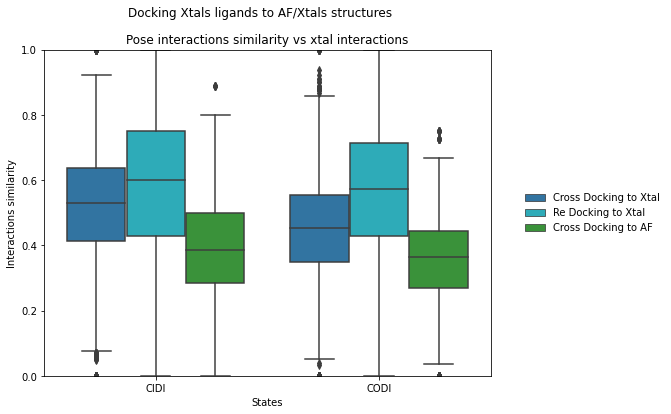

In [15]:
colors = ["#1F77B4",  "#17BECF", "#2ca02c"]
customPalette = sns.set_palette(sns.color_palette(colors))

# Create the box plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
ax = sns.boxplot(data=df_tot, x='States', y='Interactions similarity', hue='Type')

# Move the legend outside the plot area
sns.move_legend(ax, "right", bbox_to_anchor=(1.4, 0.5), ncol=1, title=None, frameon=False)

# Set the y-axis limit
plt.ylim(0, 1)

# Set titles
plt.suptitle('Docking Xtals ligands to AF/Xtals structures')
plt.title('Pose interactions similarity vs xtal interactions')

# Save the plot
plt.savefig('Interaction_accuracy_from_docking_all.jpg', dpi=300, bbox_inches='tight')  # Use bbox_inches='tight' to prevent clipping
